# Vehicle Re-identification using Transformer and Contrastive Learning

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from dataset import VehicleReIDDataset, dataloader_train_test_split
from vit import ViTEncoder
from loss import TripletLoss
from utils import get_hard_triplets, extract_embeddings
from performance_analysis import compute_cmc_rankn, compute_map

In [2]:
# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [3]:
# initilaizing model
model = ViTEncoder(
    img_size=224,
    patch_size=8,
    in_chans=3,
    embed_dim=512,
    depth=4,
    n_heads=4,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.1,
    attn_p=0.1,
    out_dim=256
)

# defining transformations
# transform = transforms.Compose([
#     transforms.Resize((384, 384), interpolation=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.225, 0.225, 0.225])
])

### Training

In [4]:
def train(model, train_loader, optimizer, loss_fn, device, val_loader=None, epochs=10):
    
    train_loss_hist = []
    val_loss_hist = []
    
    for epoch in range(epochs):
    
        train_epoch_loss = 0
        val_epoch_loss = 0

        #################### Train ####################

        model.train()
        print('Training...')
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Extract embeddings
            embeddings = model(images)

            # Hard triplet selection
            triplets = get_hard_triplets(embeddings, labels)
            if len(triplets) == 0:
                continue

            anchor, positive, negative = zip(*triplets)
            anchor = torch.stack([embeddings[i] for i in anchor])
            positive = torch.stack([embeddings[i] for i in positive])
            negative = torch.stack([embeddings[i] for i in negative])

            # Compute loss
            loss = loss_fn(anchor, positive, negative)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            # Clear memory
            del images, labels, embeddings, anchor, positive, negative, loss
            torch.cuda.empty_cache()

        train_epoch_loss /= len(train_loader)
        train_loss_hist.append(train_epoch_loss)

        #################### Validation ####################

        if val_loader:

            model.eval()
            print('Validating...')
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)

                # Extract embeddings
                embeddings = model(images)

                # Hard triplet selection
                triplets = get_hard_triplets(embeddings, labels)
                if len(triplets) == 0:
                    continue

                anchor, positive, negative = zip(*triplets)
                anchor = torch.stack([embeddings[i] for i in anchor])
                positive = torch.stack([embeddings[i] for i in positive])
                negative = torch.stack([embeddings[i] for i in negative])

                # Compute loss
                loss = loss_fn(anchor, positive, negative)

                val_epoch_loss += loss.item()

                # Clear memory
                del images, labels, embeddings, anchor, positive, negative, loss
                torch.cuda.empty_cache()

            val_epoch_loss /= len(val_loader)
            val_loss_hist.append(val_epoch_loss)

        #################### Log ####################

        print(f'Epoch {epoch+1:3}/{epochs:3} | Train Loss: {train_epoch_loss:.4f} | Validation Loss: {val_epoch_loss:.4f}')
    
    return train_loss_hist, val_loss_hist

In [5]:
# Initialize dataset and dataloader
# vric_dataset = VehicleReIDDataset(root_dir='data/VRIC_dataset/train_images', labels_file='data/VRIC_dataset/vric_train.txt', name='VRIC', transform=transform)
veri_carla_dataset = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_train', name='VeRi_CARLA', transform=transform, n_datapoints=5000)
train_loader, val_loader = dataloader_train_test_split(veri_carla_dataset, batch_size=100, test_split=0.2)

# model.load_state_dict(torch.load('trained_models/model_10_veri_carla.pth', map_location=DEVICE)) # to initialize model with pre-trained weights
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = TripletLoss(margin=0.5)

In [6]:
# Train model
train_loss_hist, val_loss_hist = train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    device=DEVICE,
    epochs=10
)

Training...


100%|██████████| 40/40 [04:45<00:00,  7.15s/it]


Validating...


100%|██████████| 10/10 [00:59<00:00,  5.95s/it]


Epoch   1/ 10 | Train Loss: 0.0307 | Validation Loss: 0.0018
Training...


100%|██████████| 40/40 [03:13<00:00,  4.83s/it]


Validating...


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


Epoch   2/ 10 | Train Loss: 0.0045 | Validation Loss: 0.0024
Training...


100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


Validating...


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch   3/ 10 | Train Loss: 0.0044 | Validation Loss: 0.0061
Training...


100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch   4/ 10 | Train Loss: 0.0059 | Validation Loss: 0.0015
Training...


100%|██████████| 40/40 [01:05<00:00,  1.64s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch   5/ 10 | Train Loss: 0.0067 | Validation Loss: 0.0056
Training...


100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch   6/ 10 | Train Loss: 0.0016 | Validation Loss: 0.0000
Training...


100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch   7/ 10 | Train Loss: 0.0029 | Validation Loss: 0.0000
Training...


100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch   8/ 10 | Train Loss: 0.0038 | Validation Loss: 0.0023
Training...


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch   9/ 10 | Train Loss: 0.0013 | Validation Loss: 0.0000
Training...


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


Validating...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

Epoch  10/ 10 | Train Loss: 0.0000 | Validation Loss: 0.0000


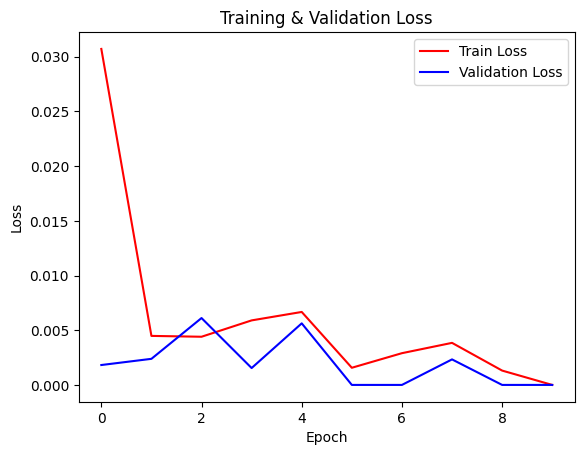

In [7]:
# Plot training loss
plt.figure()
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_hist, label='Train Loss', color='r')
plt.plot(val_loss_hist, label='Validation Loss', color='b')
plt.legend()
plt.show()

In [8]:
# Saving model
torch.save(model.state_dict(), 'trained_models/model_10_veri_carla.pth')

### Inference

In [ ]:
model.load_state_dict(torch.load('trained_models/model_10_veri_carla.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

In [ ]:
def infer(model, image_path, device=DEVICE, transform=transform):
    '''
    Extracts embeddings for a single image.
    '''
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy().flatten()

trial_image_path = './data/VeRi_CARLA_dataset/image_gallery/20220710050038_0_44.jpg'
infer(model, trial_image_path)

### Performance Analysis

In [9]:
model.load_state_dict(torch.load('trained_models/model_10_veri_carla.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=512, ou

In [10]:
veri_carla_query = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_query', name='VeRi_CARLA', transform=transform)
veri_carla_gallery = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_gallery', name='VeRi_CARLA', transform=transform)

# vric_query = VehicleReIDDataset(root_dir='data/VRIC_dataset/probe_images', labels_file='data/VRIC_dataset/vric_probe.txt', name='VRIC', transform=transform)
# vric_gallery = VehicleReIDDataset(root_dir='data/VRIC_dataset/gallery_images', labels_file='data/VRIC_dataset/vric_gallery.txt', name='VRIC', transform=transform)

query_loader = DataLoader(veri_carla_query, batch_size=1, shuffle=False)
gallery_loader = DataLoader(veri_carla_gallery, batch_size=1, shuffle=False)

query_embeddings, query_labels = extract_embeddings(model, query_loader, DEVICE)
gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_loader, DEVICE)

Mean Average Precision (mAP): 29.65%
Rank-1 Accuracy: 80.42%
Rank-5 Accuracy: 93.87%
Rank-10 Accuracy: 97.41%


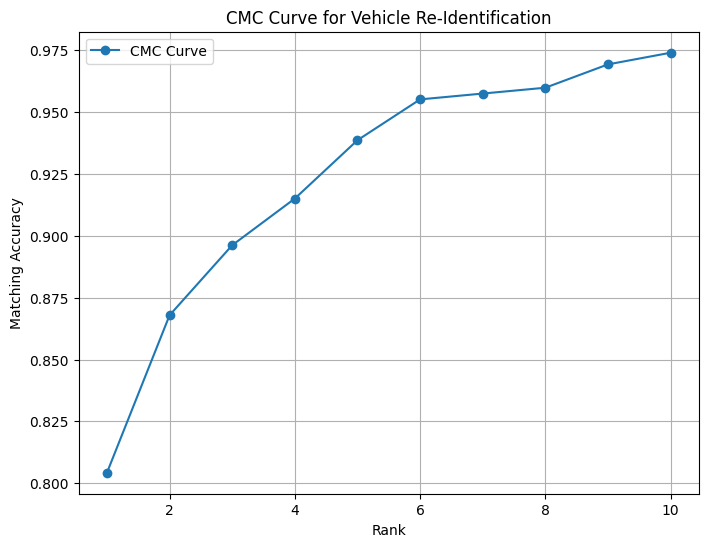

In [11]:
# Compute cosine similarity
similarity = cosine_similarity(query_embeddings, gallery_embeddings)

map_score = compute_map(similarity, query_labels, gallery_labels)
print(f'Mean Average Precision (mAP): {map_score * 100:.2f}%')

cmc_curve, rank_1, rank_5, rank_10 = compute_cmc_rankn(similarity, query_labels, gallery_labels)

print(f'Rank-1 Accuracy: {rank_1:.2f}%')
print(f'Rank-5 Accuracy: {rank_5:.2f}%' if rank_5 else '')
print(f'Rank-10 Accuracy: {rank_10:.2f}%' if rank_10 else '')

ranks = np.arange(1, len(cmc_curve) + 1)
plt.figure(figsize=(8, 6))
plt.plot(ranks, cmc_curve, marker='o', linestyle='-', label='CMC Curve')
plt.xlabel('Rank')
plt.ylabel('Matching Accuracy')
plt.title('CMC Curve for Vehicle Re-Identification')
plt.legend()
plt.grid()
plt.show()